In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# load modules
import os
import re
import numpy as np
import pandas as pd
import pickle
import glob
from collections import OrderedDict
from copy import deepcopy

import palantir
import harmony

# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings

%matplotlib inline

/usr/local/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
matplotlib.rcParams['figure.figsize'] = [18, 12]
matplotlib.rcParams['figure.dpi'] = 100
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [4]:
DATA_DIR = '/home/ec2-user/workspace/data/tag_counts/'

In [5]:
SAMPLE_NAMES = sorted([x.split('/')[-1].strip('_tag_counts.p') for x in glob.glob(DATA_DIR+'KP_Mixing_*.p')])

## Load data

In [6]:
# Load new data
v_count_dict = dict()
for samp in SAMPLE_NAMES:
    with open(DATA_DIR+'{}_tag_counts.p'.format(samp), 'rb') as in_file:
        v_count_dict[samp] = pickle.load(in_file)['v1']
        v_count_dict[samp].index = [samp+':'+str(idx) for idx in v_count_dict[samp].index.tolist()]

### Combine data

In [7]:
# do tag correction
def celltag_correction(tag_count_df):
    corrected_tag_count_df = tag_count_df.copy()
    
    for bc, counts in tag_count_df.iterrows():
        # tags in ascending order for current cell
        counts = counts[counts > 0]
        sorted_counts = counts.sort_values()
        
        for low_tag, low_count in sorted_counts.iteritems():
            #  find index of the first umi with higher count than current umi
            begin_idx = np.where(sorted_counts > low_count)[0]
            if len(begin_idx) == 0:
                # no umi has higher read count, move on
                break

            # only compare to umis with higher count and reverse to descending order
            begin_idx = begin_idx[0]
            to_compare = sorted_counts.iloc[begin_idx::].iloc[::-1]
            for high_tag, high_count in to_compare.iteritems():
                if sum(i!=j for i, j in zip(low_tag, high_tag)) == 1:
                    # update correction_dict[bc][umi] with the corrected umi 
                    corrected_tag_count_df.loc[bc, high_tag] += tag_count_df.loc[bc, low_tag]
                    corrected_tag_count_df.loc[bc, low_tag] = 0
                    
                    sorted_counts = corrected_tag_count_df.loc[bc]
                    sorted_counts = sorted_counts[sorted_counts > 0].sort_values()
                    break

    return corrected_tag_count_df


for sample in v_count_dict:
    print(sample)
    v_count_dict[sample] = celltag_correction(v_count_dict[sample])
    v_count_dict[sample] = v_count_dict[sample].loc[:, (v_count_dict[sample] != 0).any(axis=0)]

KP_Mixing_A
KP_Mixing_B
KP_Mixing_C
KP_Mixing_D


In [8]:
for sample in v_count_dict:
    print(v_count_dict[sample].shape)

(352, 2277)
(282, 2311)
(266, 2055)
(296, 1774)


# combine data

In [9]:
all_cells = list()
all_genes = list()

# Update index and genes
all_cells, all_genes = [], set()
for sn in ['KP_Mixing_{}'.format(a) for a in 'ABCD']:
    dic = v_count_dict[sn]
    all_cells += dic.index.tolist()
    all_genes = all_genes.union(dic.columns)
all_genes = list(all_genes)

combined_counts = pd.DataFrame(np.zeros([len(all_cells), len(all_genes)]), index=all_cells, columns=all_genes)
for sn in ['KP_Mixing_{}'.format(a) for a in 'ABCD']:
    dic = v_count_dict[sn]
    combined_counts.loc[dic.index, dic.columns] = dic

combined_counts = combined_counts.loc[:, (combined_counts != 0).any(axis=0)]
print(combined_counts.shape)

(1196, 4595)


# preprocessing

In [10]:
# preprocessing
tag_counts = combined_counts.copy()

# remove entries with 1 molecule
tag_counts[tag_counts <= 1] = 0

# binarize
tag_counts[tag_counts > 0] = 1

# remove tags found in only one cell (PROBLEM: if there a cell has no clonal sibling, its true tags will be removed and fake ambient tags will be retained)
#tag_counts = tag_counts.loc[:, tag_counts.sum(axis=0) > 1]
#tag_counts = tag_counts.loc[tag_counts.sum(axis=1) > 0, :]

# remove cells with less than 2 tags/more than 20 tags and empty columns
tag_counts = tag_counts.loc[tag_counts.sum(axis=1) > 1, :]
tag_counts = tag_counts.loc[tag_counts.sum(axis=1) < 20, :]

# clean up empty rows or columns
tag_counts = tag_counts.loc[:, (tag_counts != 0).any(axis=0)]
tag_counts = tag_counts.loc[(tag_counts != 0).any(axis=1), :]

print(tag_counts.shape)

(761, 2811)


## v1 distributions

Text(0.5, 1.0, 'tags per cell')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


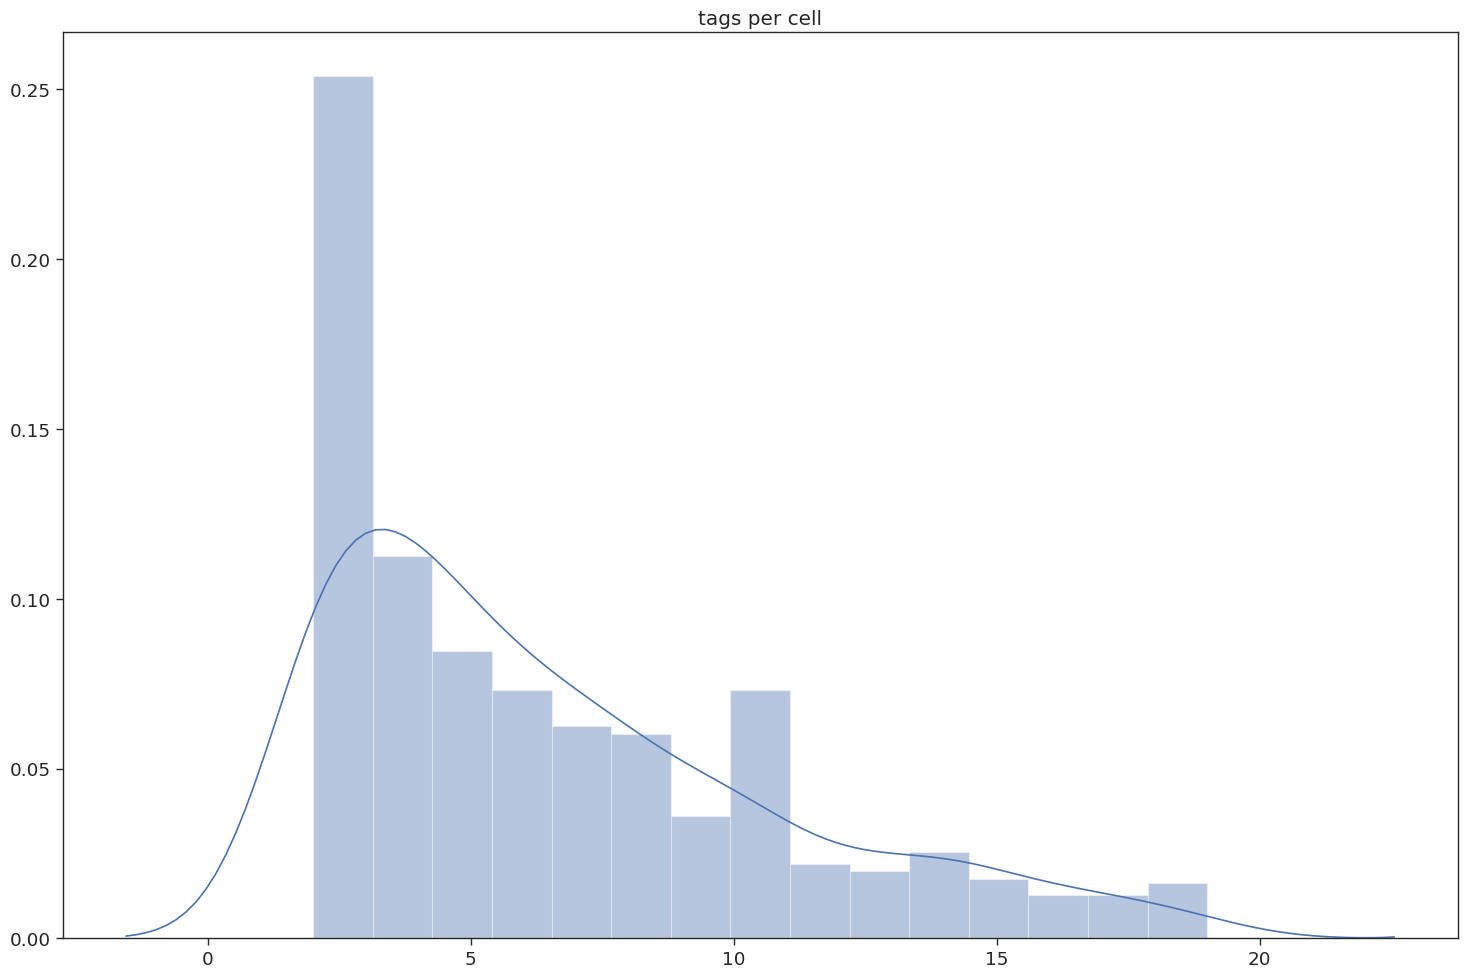

In [11]:
# v1 tags
plt.figure()

tags_per_cell = tag_counts.sum(axis=1)
weights = np.ones_like(tags_per_cell)/float(len(tags_per_cell))

sns.distplot(tags_per_cell, bins=15)
plt.title('tags per cell')

In [12]:
tag_counts.sum(axis=1).mean()

6.5584756898817345

## Jaccard similarity and clone calling

In [13]:
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, optimal_leaf_ordering

In [14]:
# calculate jaccard similarity between cells
jacc = 1 - pairwise_distances(tag_counts.values, metric='jaccard')

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


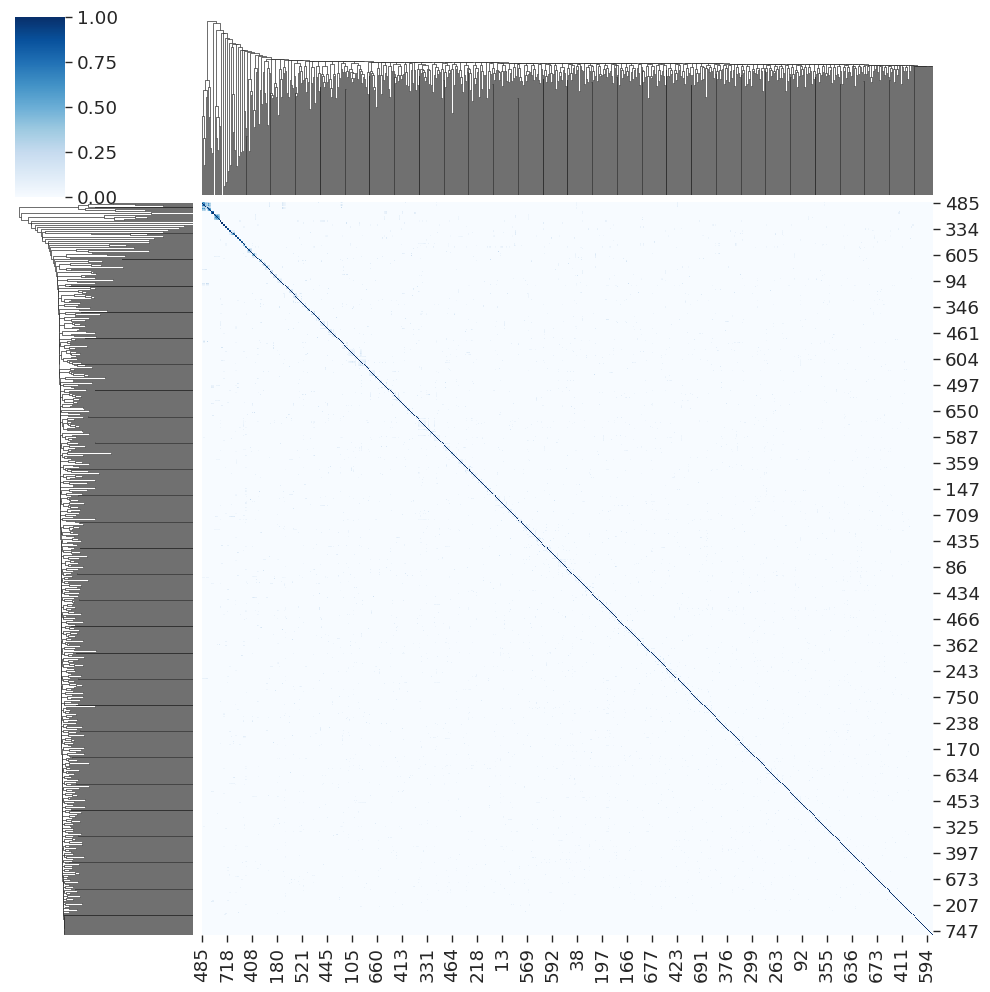

In [15]:
# plot pairwise jaccard similarity for celltag
p_0 = sns.clustermap(jacc, cmap=matplotlib.cm.Blues)

In [16]:
# convert jaccard to binary clone matrix
bin_clone = jacc.copy()
bin_clone[bin_clone < 0.7] = 0
bin_clone[bin_clone > 0] = 1

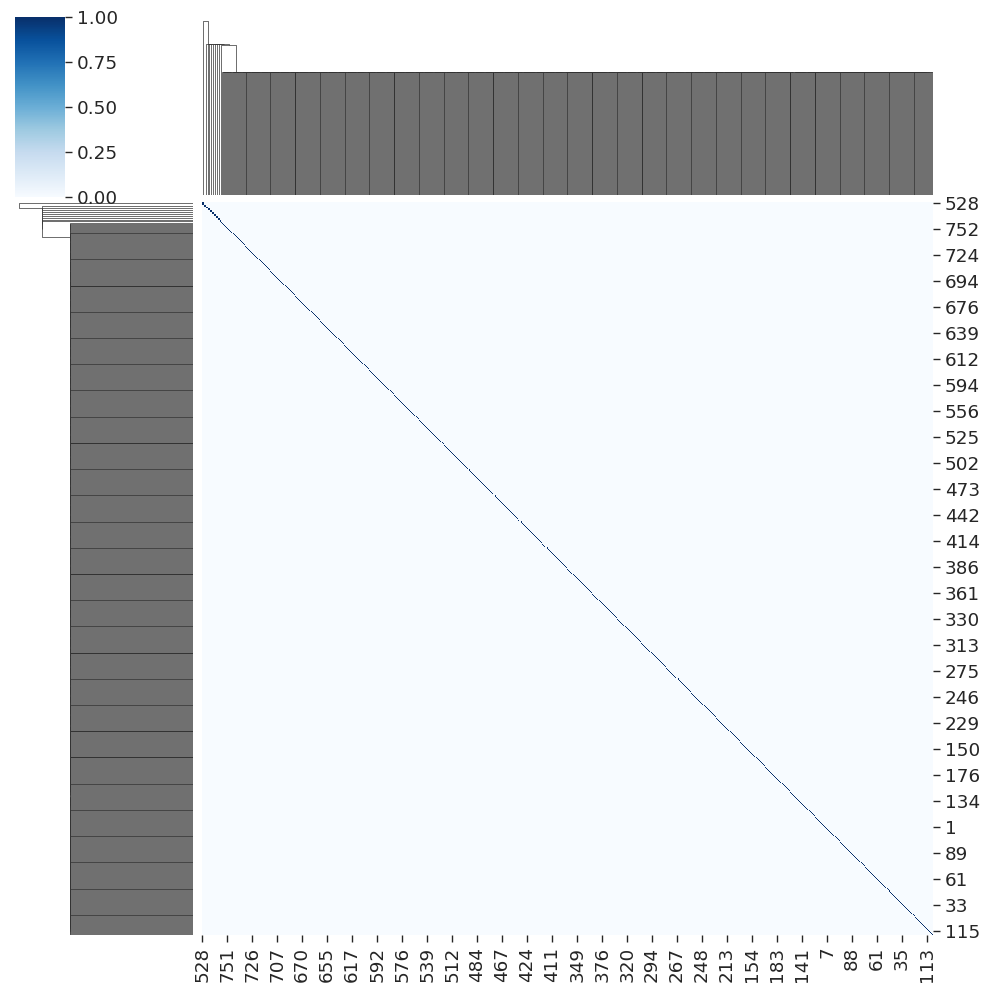

In [18]:
# plot pairwise jaccard similarity for celltag
p = sns.clustermap(bin_clone, cmap=matplotlib.cm.Blues)

In [55]:
zoom_in_idx = p.dendrogram_row.reordered_ind[:15]
tag_counts.index[zoom_in_idx]

Index(['KP_Mixing_C:GTAGTCAGTACCAGGA', 'KP_Mixing_C:ATCACACGTGTTGTGG',
       'KP_Mixing_C:ATCACGAGGCTACGTT', 'KP_Mixing_C:GTCCACATGTCGTGTT',
       'KP_Mixing_D:TAGAGCTCGTAACTGG', 'KP_Mixing_B:CGTTGCAAGGCATACT',
       'KP_Mixing_D:GTTCTGACGAAGGTTC', 'KP_Mixing_B:GCGTTGTTACCTGACT',
       'KP_Mixing_D:GTCTCCTTCCATTGGA', 'KP_Mixing_C:CAACAGGTCCTATACC',
       'KP_Mixing_D:GAGCTTGTTCGTTCGT', 'KP_Mixing_C:ACACACTCATGGTTGC',
       'KP_Mixing_C:TGCTTGGTAGACCGTA', 'KP_Mixing_C:AGTGCTGTTACCAGGA',
       'KP_Mixing_C:GAACGCTTGACTTAGG'],
      dtype='object')

In [47]:
reordered_bin = bin_clone[p.dendrogram_row.reordered_ind, :][:, p.dendrogram_row.reordered_ind]

In [52]:
reordered_bin[:15, :15]

array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.

/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


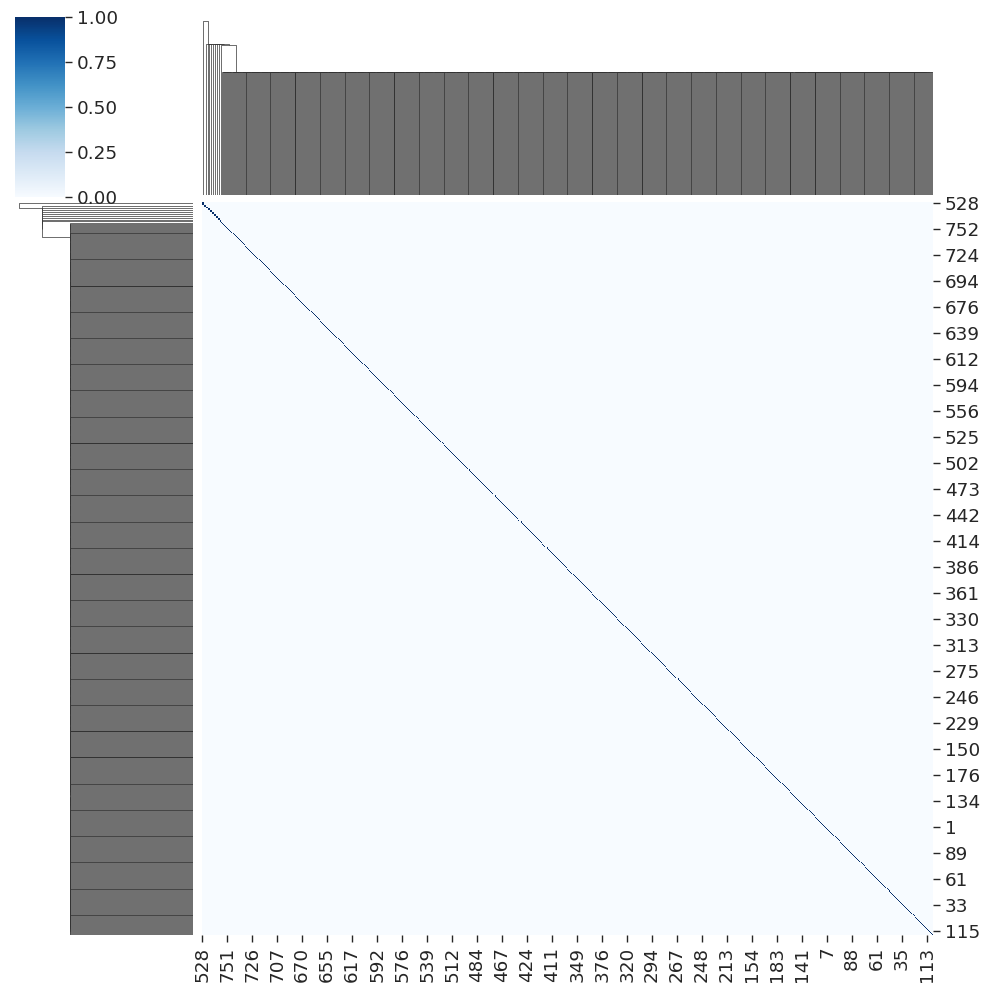

In [33]:
# plot pairwise jaccard similarity for celltag
p = sns.clustermap(bin_clone, cmap=matplotlib.cm.Blues)

# algorithm

In [ ]:
def overlap_distance(x, y):
    return (1 - np.dot(x, y) / np.min([np.sum(x), np.sum(y)]))

In [ ]:
# distance matrix
D = pairwise_distances(combined_bin_dict['Bottleneck_TF'], metric=overlap_distance)

In [ ]:
# plot pairwise jaccard similarity for celltag
p_dmso = sns.clustermap(1-D, cmap=matplotlib.cm.Blues)